In [43]:
from nltk.tokenize import RegexpTokenizer
import numpy as np
import re
from keras.utils import pad_sequences
from keras.callbacks import EarlyStopping
import random,copy,string
import matplotlib.pyplot as plt
import nltk
import multiprocessing as mp
import random,copy,string
from scipy.stats import pearsonr
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Conv1D,  MaxPool1D, Flatten
from tensorflow.python.keras.layers import Lambda, multiply, concatenate, Dense
from tensorflow.python.keras.callbacks import Callback
# from keras.optimizers import Adam
from keras.models import load_model
import tensorflow as tf
# nltk.download('punkt')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###HYPER - PARAMETERS

In [2]:
sentence_length, padding_size = 40,40
embedding_size = 300
no_of_filters = 300
kernel_size = 1
cnn_activation_function = 'relu'
cnn_kernel_initializer = 'he_uniform'
no_of_units_ds1 = 300
output_units = 6
optimizer = 'adam'
batch_size = 300
num_batches = 2

### Glove embedding

In [4]:
word_to_index = dict()
index_to_word = dict()
index = 1
embed_dict = {}
embed_dict['oov'] = np.zeros(300)

with open('/content/drive/MyDrive/Colab Notebooks/Working/glove.6B.300d.txt','r') as f:  #/content/drive/MyDrive/NLP/glove.840B.300d.txt /content/drive/MyDrive/smai/glove/glove.6B.300d.txt
  for line in f:
    values = line.split(' ')
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    embed_dict[word]=vector
    word_to_index[word] = index
    index_to_word[index] = word
    index+=1

word_to_index['oov'] = 0
index_to_word[0] = 'oov'

### Data Pre-Processing 

In [11]:
def generate_embedding_matrix(sentence):

    tokens_ = nltk.word_tokenize(sentence)
    tokens = []

    for i in tokens_:
      if i not in string.punctuation:
        tokens.append(i.lower())
    # sentence = sentence.lower()
    # sentence = re.sub('[^a-z0-9]',' ',sentence)
    # Tokenize the sentence and do the padding
    
    word_to_vec = []
    # Loop over the tokens and generate their embeddings
    for i, token in enumerate(tokens):
        if token in word_to_index:
            word_to_vec.append(word_to_index[token])
        else:
            word_to_vec.append(word_to_index['oov'])

    # print(word_to_vec)

    word_to_vec = np.array(word_to_vec)
    word_to_vec=word_to_vec.reshape(1,word_to_vec.shape[0])
    word_to_vec = pad_sequences(word_to_vec, maxlen=sentence_length, truncating='post', padding='post')

    # Initialize an empty matrix with shape (sentence_length, 300)
    embedding_matrix = np.zeros((sentence_length, 300))
    
    # Loop over the tokens and generate their embeddings
    for i, token in enumerate(word_to_vec[0]):
        embedding_matrix[i, :] = embed_dict[index_to_word[token]]
    return embedding_matrix

In [12]:
def get_input(filename):
  with open(filename) as f:
    lines = [line.rstrip('\n') for line in f]
  s1_embedding_matrix_list,s2_embedding_matrix_list,actual_scores = list(),list(),list()
  for line in lines:
    # _,_,_,_,score,s1,s2 = line.split('\t')[:7]
    s1,s2,score = line.split('\t')
    s1_embedding_matrix_list.append(generate_embedding_matrix(s1))
    s2_embedding_matrix_list.append(generate_embedding_matrix(s2))
    actual_scores.append(eval(score))

  s1_embedding_matrix_list = np.array(s1_embedding_matrix_list)
  s2_embedding_matrix_list = np.array(s2_embedding_matrix_list)
  actual_scores = np.array(actual_scores)
  return s1_embedding_matrix_list,s2_embedding_matrix_list,actual_scores

In [13]:
def generate_one_hot_lists(arr):
    # Compute the fractional parts of the array elements
    fracs = np.mod(arr, 1)
    # Compute the distances from the nearest integers
    cfracs = 1 - fracs
    actual =  np.int64(arr - fracs)
    dists = np.minimum(fracs, 1 - fracs)

    # Compute the one-hot encoding of the distances
    one_hots = np.zeros((arr.shape[0], 6))
    for i in range(len(arr)):
      temp = np.zeros(6,)
      if fracs[i] == 0.0:
        temp[actual[i]] = 1.0
      else:
        temp[actual[i]] = cfracs[i]
        temp[actual[i]+1] = fracs[i] 
      one_hots[i,:] = temp 
    return one_hots

In [14]:
train = '/content/drive/MyDrive/Colab Notebooks/Working/en/en-train.txt'
validation ='/content/drive/MyDrive/Colab Notebooks/Working/en/en-val.txt'
test = '/content/drive/MyDrive/Colab Notebooks/Working/en/test-sentences-2017.txt'

train_data, validation_data,  test_data = get_input(train), get_input(validation),  get_input(test)

train_x_1,      train_x_2,      train_y       = train_data[0],      train_data[1],      generate_one_hot_lists(train_data[2]) 
validation_x_1, validation_x_2, validation_y  = validation_data[0], validation_data[1], generate_one_hot_lists(validation_data[2]) 
test_x_1,       test_x_2,       test_y        = test_data[0],       test_data[1],       generate_one_hot_lists(test_data[2]) 

In [24]:
#Analyise Dataset..
def get_avg_sentence_length(sentences):
    # Get the total number of words in all sentences
    total_words = sum([len(sentence.split()) for sentence in sentences])

    # Calculate the average sentence length
    avg_sentence_length = total_words / len(sentences)

    return avg_sentence_length

def plot_sentence_length_variation(sentences):
    # Get the length of each sentence
    sentence_lengths = [len(sentence.split()) for sentence in sentences]

    # Plot the sentence length distribution
    plt.hist(sentence_lengths, bins=range(0, max(sentence_lengths) + 1, 5))
    plt.title('Sentence Length Distribution')
    plt.xlabel('Sentence Length')
    plt.ylabel('Number of Sentences')
    plt.show()


Average sentence length: 11.32315750093528


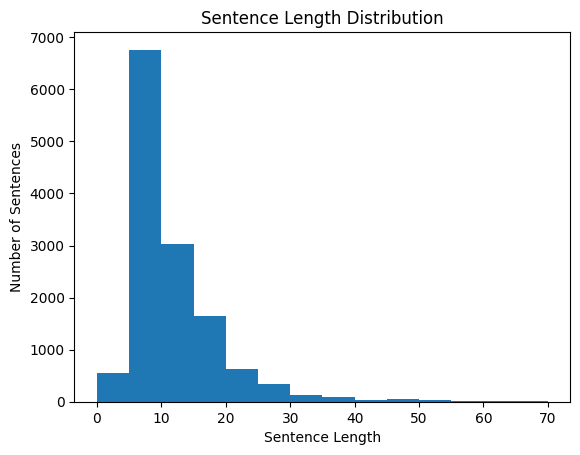

In [25]:
with open(train) as f:
    lines = f.readlines()
s1,s2 = list(),list()
for line in lines:
  a,b,s = line.split('\t')
  s1.append(a)
  s2.append(b)

avg_sentence_length = get_avg_sentence_length(s1)
print('Average sentence length:', avg_sentence_length)
plot_sentence_length_variation(s1)

In [28]:
count = 0
for sentence in s1:
    if len(sentence.split()) <= 40:
        count += 1
print('Number of sentences greater than 40 words:', count)
print('Percentage they are covering:',count/len(s1)*100)

Number of sentences greater than 40 words: 13194
Percentage they are covering: 98.72053872053871


In [19]:
train_x_1.shape,validation_x_1.shape,test_x_1.shape,test_y.shape

((13365, 40, 300), (1500, 40, 300), (250, 40, 300), (250, 6))

### Model

In [30]:
def _lossfunction(y_true,y_pred):
  ny_true = y_true[:,1] + 2*y_true[:,2] + 3*y_true[:,3] + 4*y_true[:,4] + 5*y_true[:,5]
  ny_pred = y_pred[:,1] + 2*y_pred[:,2] + 3*y_pred[:,3] + 4*y_pred[:,4] + 5*y_pred[:,5]
  my_true = K.mean(ny_true)
  my_pred = K.mean(ny_pred)
  var_true = (ny_true - my_true)**2
  var_pred = (ny_pred - my_pred)**2
  return -K.sum((ny_true-my_true)*(ny_pred-my_pred),axis=-1) / (K.sqrt(K.sum(var_true,axis=-1)*K.sum(var_pred,axis=-1)))

In [31]:
sentence1 = Input(shape=(sentence_length,embedding_size))
sentence2 = Input(shape=(sentence_length,embedding_size))
cnn_layer = Conv1D(filters = no_of_filters,
                    kernel_size = kernel_size,
                    activation='relu',
                    kernel_initializer=cnn_kernel_initializer)

cnn_layer1 = cnn_layer(sentence1)
cnn_layer2 = cnn_layer(sentence2)

max_pool = MaxPool1D(pool_size=padding_size-kernel_size+1)

max_pool1 = max_pool(cnn_layer1)
max_pool2 = max_pool(cnn_layer2)
flatten = Flatten()

flatten1 = flatten(max_pool1)
flatten2 = flatten(max_pool2)

absDifference = Lambda(lambda X:K.abs(X[0] - X[1]))([flatten1,flatten2])

mulDifference = multiply([flatten1,flatten2])

allDifference = concatenate([absDifference,mulDifference])

Denselayer_1 = Dense(no_of_units_ds1,activation='tanh',kernel_initializer=cnn_kernel_initializer)(allDifference)

output = Dense(name='output',units=output_units,activation='softmax',kernel_initializer=cnn_kernel_initializer)(Denselayer_1)

model = Model(inputs=[sentence1,sentence2], outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40, 300)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 40, 300)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 40, 300)      90300       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 1, 300)       0           conv1d[0][0]                 

In [38]:
model.compile(loss=_lossfunction, optimizer='Adam')

In [39]:
def eval_model(model):
  predictionclasses = list(model.predict([validation_x_1,validation_x_2]))
  prediction = np.dot(np.array(predictionclasses),np.arange(6))
  goldlabels = validation_data[2]
  result=pearsonr(prediction, goldlabels)[0]
  print('Validation PCC:',result)
  return round(result,4)

In [40]:
class Evaluate(Callback):
  def __init__(self, task, wfname):
    self.task       = task
    self.bestresult = 0.0
    self.wfname     = wfname
  def on_epoch_end(self, epoch, logs={}):
    validresult = eval_model(self.task)
    if validresult > self.bestresult:
      self.bestresult = validresult
      self.task.save(self.wfname)

In [41]:
early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=4,
        verbose=1,
        mode="min",
        restore_best_weights=True, 
     )

In [42]:
history = model.fit(x=[train_x_1,train_x_2],
                    y=train_y,
                    callbacks=[Evaluate(model,'/content/drive/MyDrive/Colab Notebooks/Working/best_model_cnn.h5')],
                    batch_size=batch_size,
                    epochs = 60,
                    verbose = 1)

Epoch 1/60
45/45 [==============================] - 16s 327ms/step - loss: -0.8721
Validation PCC: 0.8216269240674814
Epoch 2/60
45/45 [==============================] - 12s 276ms/step - loss: -0.9140
Validation PCC: 0.8217212053374867
Epoch 3/60
45/45 [==============================] - 11s 251ms/step - loss: -0.9355
Validation PCC: 0.8197238669065215
Epoch 4/60
45/45 [==============================] - 13s 275ms/step - loss: -0.9511
Validation PCC: 0.821146517615798
Epoch 5/60
45/45 [==============================] - 13s 290ms/step - loss: -0.9621
Validation PCC: 0.8173039259726749
Epoch 6/60
45/45 [==============================] - 13s 297ms/step - loss: -0.9692
Validation PCC: 0.8161577832362638
Epoch 7/60
45/45 [==============================] - 13s 289ms/step - loss: -0.9743
Validation PCC: 0.81506817494134
Epoch 8/60
45/45 [==============================] - 13s 287ms/step - loss: -0.9767
Validation PCC: 0.8202755645041007
Epoch 9/60
45/45 [==============================] - 13s 297

In [50]:
# loaded_model = load_model('/content/drive/MyDrive/Colab Notebooks/Working/best_model_cnn')

In [51]:
predictionclasses = list(model.predict([test_x_1,test_x_2]))
prediction = np.dot(np.array(predictionclasses),np.arange(6))
goldlabels = test_data[2]
pearsonr(np.round(prediction,4), goldlabels)[0]

0.7738344798623414